In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
sns.set()

In [2]:
data = datasets.fetch_california_housing(data_home='data/house', as_frame=True).frame

In [3]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


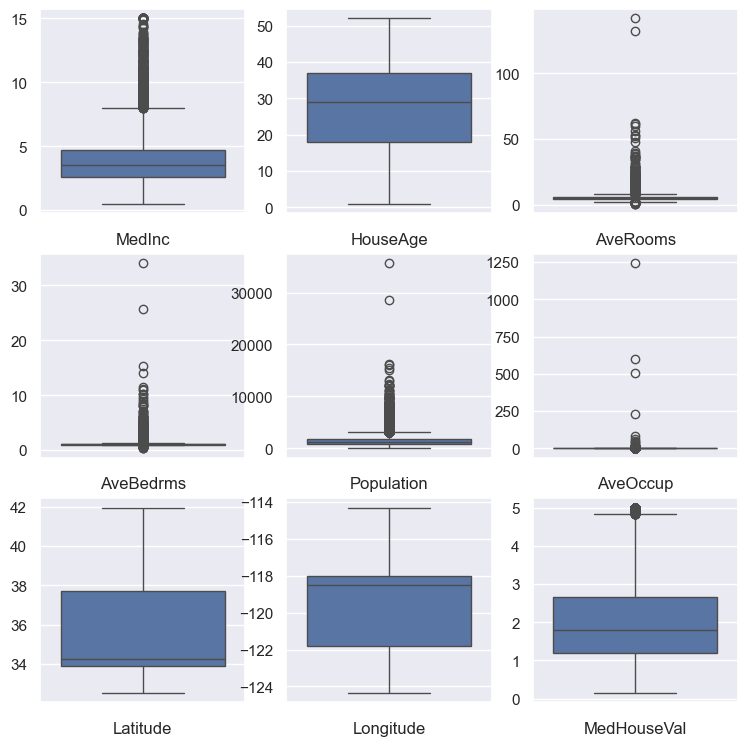

In [5]:
plt.figure(figsize=(9, 9))
for i, col in enumerate(data.columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=data, y = col)
    plt.xlabel(col)
    plt.ylabel('')

<Axes: >

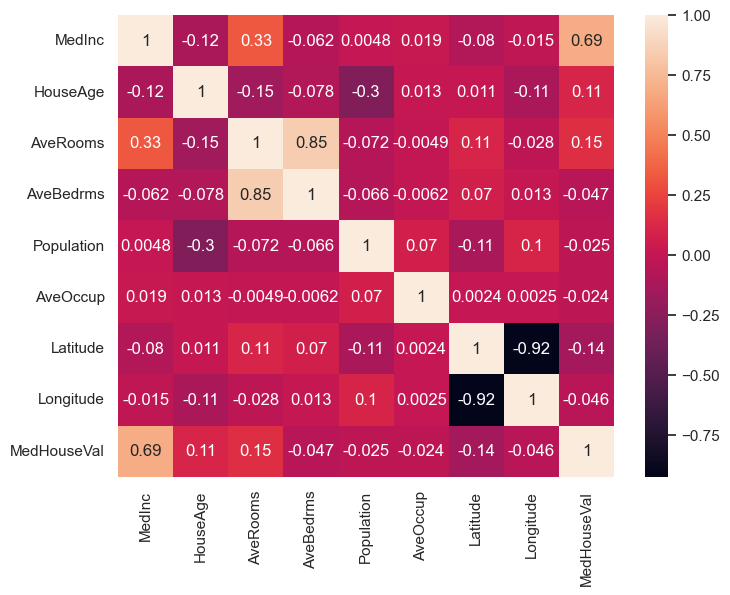

In [6]:
plt.figure(figsize=(8, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)

In [7]:
data_scaled = data.copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_scaled)# 归一化

In [8]:
X_data = data_scaled[:,:-1]
y_lab = data.values[:,-1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_lab, test_size=0.2, random_state=37)# 划分测试集

In [10]:
def get_best_parameters(model, param_dist, x_data, y_data):# 网格搜索
    gs = GridSearchCV(model, param_dist, scoring='r2', verbose=0, error_score='raise')
    gs.fit(x_data, y_data)
    print(f'Best parameters: {gs.best_params_}, score: {gs.best_score_}')
    tuned_model = gs.best_estimator_# 最佳模型
    parameters = tuned_model.get_params()# 最佳模型超参数
    return tuned_model, parameters

In [11]:
# def get_best_parameters(model, mode, param_dist, x_data, y_data, n_jobs=njobs, iters=10, random_state=None):# 可选择模式的搜索
#     if mode == 'Grid':
#         gs = GridSearchCV(model, param_dist, verbose=3, error_score='raise', n_jobs=n_jobs)
#         gs.fit(x_data, y_data)
#         print(f'Best parameters: {gs.best_params_}, score: {gs.best_score_}')
#         tuned_model = gs.best_estimator_
#     elif mode == 'Random':
#         rs = RandomizedSearchCV(model, param_dist, verbose=3, error_score='raise', n_iter=iters, random_state=random_state, n_jobs=n_jobs)
#         rs.fit(x_data, y_data)
#         print(f'Best parameters: {rs.best_params_}, score: {rs.best_score_}')
#         tuned_model = rs.best_estimator_
#     else:
#         tuned_model = None
#         print('Wrong mode')
#     return tuned_model

In [12]:
def model_performance(model, x_data, y_data):# 回归模型评估
    y_pred = model.predict(x_data)
    mae = mean_absolute_error(y_data, y_pred)
    rmse = (mean_squared_error(y_data, y_pred))**0.5
    r2 = r2_score(y_data, y_pred)
    return mae, rmse, r2

In [13]:
# def model_performance(model, x_data, y_data):# 分类模型评估
#     y_pred = model.predict(x_data)
#     report = classification_report(y_data, y_pred)# 分类评估报告
#     print(report)
#     conf_matrix = confusion_matrix(y_data, y_pred)# 混淆矩阵
#     plot_confusion_matrix(conf_mat=conf_matrix, show_absolute=False, show_normed=True, colorbar=True)

# XGBoost

In [14]:
xgb_parameters = {
    'n_estimators': [100, 300],
    'min_child_weight': [4, 6],
    'max_depth': [4, 6],
    'gamma': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0.01, 1],
    'reg_lambda': [0.01, 1],
    'learning_rate': [0.01, 0.1]
}# XGBoost部分超参数

In [15]:
# 部分随机搜索超参数
# xgbc_parameters = [
#     {
#         'tree_method': ['exact'],
#         'max_depth': randint(1, 10),
#         'learning_rate': reciprocal(0.01, 0.5),
#         'gamma': [0, 0.1, 1, 10],
#         'min_child_weight': [0, 0.1, 1, 10],
#         'subsample': uniform(0, 1),
#         'reg_alpha': uniform(0, 0.3),
#         'reg_lambda': uniform(0.7, 0.6),
#         'colsample_bytree': uniform(0.5, 0.5),
#         'colsample_bylevel': uniform(0.5, 0.5),
#         'colsample_bynode': uniform(0.5, 0.5)
#     },
#     {
#         'tree_method': ['approx'],
#         'max_depth': randint(0, 10),
#         'max_leaves': randint(0, 50),
#         'max_bin': randint(2, 500),
#         'grow_policy': ['depthwise', 'lossguide'],
#         'learning_rate': reciprocal(0.01, 0.5),
#         'gamma': [0, 0.1, 1, 10],
#         'min_child_weight': [0, 0.1, 1, 10],
#         'subsample': uniform(0, 1),
#         'reg_alpha': uniform(0, 0.3),
#         'reg_lambda': uniform(0.7, 0.6),
#         'colsample_bytree': uniform(0.5, 0.5),
#         'colsample_bylevel': uniform(0.5, 0.5),
#         'colsample_bynode': uniform(0.5, 0.5)
#     },
#     {
#         'tree_method': ['hist'],
#         'max_depth': randint(0, 10),
#         'max_leaves': randint(0, 50),
#         'max_bin': randint(2, 500),
#         'grow_policy': ['depthwise', 'lossguide'],
#         'learning_rate': reciprocal(0.01, 0.5),
#         'gamma': [0, 0.1, 1, 10],
#         'min_child_weight': [0, 0.1, 1, 10],
#         'subsample': uniform(0, 1),
#         'reg_alpha': uniform(0, 0.3),
#         'reg_lambda': uniform(0.7, 0.6),
#         'colsample_bytree': uniform(0.5, 0.5),
#         'colsample_bylevel': uniform(0.5, 0.5),
#         'colsample_bynode': uniform(0.5, 0.5)
#     }
# ]

In [16]:
xgb = XGBRegressor()
xgb, xgb_parameters = get_best_parameters(xgb, xgb_parameters, X_train, y_train)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 0.01, 'subsample': 0.8}, score: 0.844117642631122


In [17]:
model_performance(xgb, X_test, y_test)

(0.2815841970237281, 0.42045263501944735, 0.8634310638354596)

# lightGBM

In [18]:
lgb_parameters = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6],
    'num_leaves': [4, 7],
    'subsample': [0.6, 0.8],
    'reg_alpha': [0.01, 1],
    'reg_lambda': [0.01, 1],
    'learning_rate': [0.01, 0.1]
}# lightGBM部分超参数

In [19]:
lgb = LGBMRegressor(verbosity=-1)
lgb, lgb_parameters = get_best_parameters(lgb, lgb_parameters, X_train, y_train)# 下面的报错不影响

D:\Anaconda3\envs\normal_3_11_5\Lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Anaconda3\envs\normal_3_11_5\Lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Anaconda3\envs\normal_3_11_5\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Anaconda3\envs\normal_3_11_5\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Anaconda3\envs\normal_3_11_5\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'num_leaves': 7, 'reg_alpha': 1, 'reg_lambda': 0.01, 'subsample': 0.6}, score: 0.8228224737847869


In [20]:
model_performance(lgb, X_test, y_test)

(0.31485834663460316, 0.4553063702336303, 0.8398506344817868)

# Stacking

In [21]:
class Stk:
    def __init__(self, models):# model为模型列表，最后一个模型为回归器
        self.base_models = models[:-1]
        self.meta_model = models[-1]
    def fit(self, x, y, mode, k=5):# k为交叉验证折数
        kf = KFold(n_splits=k)
        output_l1_tr = pd.DataFrame()# 为第一层训练集输出创建空Dataframe
        output_l1_ts = pd.DataFrame()# 为第一层测试集输出创建空Dataframe
        for model_i, mod in enumerate(self.base_models):# 每个模型循环一次
            output_l1_tr[f'{model_i}'] = np.zeros(x.shape[0])# 为当前模型在Dataframe中创建列，用零填充
            output_l1_ts[f'{model_i}'] = np.zeros(X_test.shape[0])# 为当前模型在Dataframe中创建列，用零填充
            output_ts = np.zeros(X_test.shape[0])# 为计算训练集各折均值创建0数组
            for train_index, val_index in kf.split(x):# 取得k折交叉验证索引
                x_tr, x_v = x[train_index], x[val_index]# 根据索引对数据进行切片
                y_tr, y_v = y[train_index], y[val_index]
                mod.fit(x_tr, y_tr)# 当前模型，当前折，训练模型
                for x_vi in val_index:# 为便于对应数据与目标变量位置，每个数据进行一次预测，val_index为当前折验证集索引
                    output_l1_tr.iloc[x_vi, model_i] = mod.predict(x[x_vi].reshape(1, -1))
                output_ts += mod.predict(X_test)# 加上当前折训练集预测值
            output_ts /= k# 对当前模型训练集求均值
            output_l1_ts.iloc[:, model_i] = output_ts# 将均值填入Dataframe
        if mode == 'Classic':# 如果为普通Stacking
            self.meta_model.fit(output_l1_tr.values, y)# 训练回归器
            return self.meta_model.predict(output_l1_ts.values)# 输出训练集预测值
        elif mode == 'Improve':# 如果为使用原始数据的多层Stacking
            input_l2_tr = np.concatenate((output_l1_tr.values, x), axis=1)# 与原始数据拼接
            input_l2_ts = np.concatenate((output_l1_ts.values, X_test), axis=1)
            output_l2_tr = pd.DataFrame()# 创建空Dataframe
            output_l2_ts = pd.DataFrame()
            for model_i, mod in enumerate(self.base_models):# 下面为重复上一层
                output_l2_tr[f'{model_i}'] = np.zeros(input_l2_tr.shape[0])
                output_l2_ts[f'{model_i}'] = np.zeros(input_l2_ts.shape[0])
                output_ts = np.zeros(input_l2_ts.shape[0])
                for train_index, val_index in kf.split(input_l2_tr):
                    x_tr, x_v = input_l2_tr[train_index], input_l2_tr[val_index]
                    y_tr, y_v = y[train_index], y[val_index]
                    mod.fit(x_tr, y_tr)
                    for x_vi in val_index:
                        output_l2_tr.iloc[x_vi, model_i] = mod.predict(input_l2_tr[x_vi].reshape(1, -1))
                    output_ts += mod.predict(input_l2_ts)
                output_ts /= k
                output_l2_ts.iloc[:, model_i] = output_ts
            input_l3_tr = np.concatenate((output_l2_tr.values, x), axis=1)# 继续拼接原始数据
            input_l3_ts = np.concatenate((output_l2_ts.values, X_test), axis=1)
            output_l3_tr = pd.DataFrame()
            output_l3_ts = pd.DataFrame()
            for model_i, mod in enumerate(self.base_models):
                output_l3_tr[f'{model_i}'] = np.zeros(input_l3_tr.shape[0])
                output_l3_ts[f'{model_i}'] = np.zeros(input_l3_ts.shape[0])
                output_ts = np.zeros(input_l3_ts.shape[0])
                for train_index, val_index in kf.split(input_l3_tr):
                    x_tr, x_v = input_l3_tr[train_index], input_l3_tr[val_index]
                    y_tr, y_v = y[train_index], y[val_index]
                    mod.fit(x_tr, y_tr)
                    for x_vi in val_index:
                        output_l3_tr.iloc[x_vi, model_i] = mod.predict(input_l3_tr[x_vi].reshape(1, -1))
                    output_ts += mod.predict(input_l3_ts)
                output_ts /= k
                output_l3_ts.iloc[:, model_i] = output_ts
            self.meta_model.fit(output_l3_tr.values, y)# 回归器输入数据没有拼接原始数据
            return self.meta_model.predict(output_l3_ts.values)# 输出训练集预测数据
        else:
            print('Invalid mode')# mode输入错误
    def evaluate(self, x, y, mode, k=5):# 对模型进行评估
        y_pre = self.fit(x, y, mode, k)# 调用fit进行训练
        mae = mean_absolute_error(y_test, y_pre)
        rmse = (mean_squared_error(y_test, y_pre))**0.5
        r2 = r2_score(y_test, y_pre)
        print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

In [22]:
cbr = CatBoostRegressor(verbose=False)# Catboost
rr = Ridge()# 岭回归
rfr = RandomForestRegressor()# 随机森林回归
svr = SVR()# 支持向量机

In [23]:
model_stk = Stk([xgb, cbr, rr, rfr, svr, lgb])
model_stk.evaluate(X_train, y_train, mode='Classic')

MAE: 0.2736216607284855, RMSE: 0.4169410327201513, R2: 0.8657027731900842


In [24]:
model_stk.evaluate(X_train, y_train, mode='Improve')

MAE: 0.2705561622953708, RMSE: 0.41338562614528673, R2: 0.8679834094358918
